# Read and process soil water content sensors


location of soil sensors and their numbers											
						
|Port| Sensor No | Place| depth | mTAW |
|:-----------:|:-----------:|:--------------------:|:--------------------------------:|:---------------:|
|   1   |  37   |  1 | 70 |  
|   2   |  3    |  1 | 40 |  
|   4   |  28   |  1 | 20 |  
|   5   |  41   |  2 | 70 | 
|   7   |  29   |  2 | 20 | 
|   8   |  4  |  2 | 40 | 
|   10  |  x   |  3 | x |  
|   11  |  x   |  3 | x |  
|   12  |  x   |  3 | x | 


# Import Python modules

In [1]:
import pandas as pd
import xlrd
import os
import numpy as np
import glob
import matplotlib.pyplot as plt
#from pandasql import sqldf
import datetime
import csv
import pdb
from tqdm.notebook import tqdm
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import FuncFormatter
from matplotlib.legend import Legend
def minor_formatter(x, ind):
    # only format if we don't overlap with a major tick
    if np.mod(x, 1) < .1:
        return ''
    return '{:.1f}'.format(np.mod(x, 1))
def alternate_formatter(x, ind):
    rm = np.mod(x, 1)
    if np.abs(rm) < .1:
        return '{:d}'.format(int(x))
    return '{:.1f}'.format(rm)

# Read data file

In [2]:
path1 = os.getcwd()
path = os.path.join(path1, 'Data_Callibration')
file = os.path.join(path, 'RawData.csv')
Cal = pd.read_csv(file,sep=';', header=0)
print(Cal)

    SensorNumber   RawValue  KnownVWC
0              7  27.192825     0.353
1              7  25.560288     0.254
2              7  23.913115     0.209
3             28  27.711502     0.353
4             28  26.337332     0.254
5             28  24.516957     0.209
6             41  28.118244     0.353
7             41  26.337332     0.254
8             41  24.753454     0.209
9             43  27.192825     0.353
10            43  25.218349     0.254
11            43  23.913115     0.209
12             3  28.418761     0.353
13             3  26.337332     0.254
14             3  25.446928     0.209
15            29  28.418761     0.353
16            29  25.673040     0.254
17            29  24.635553     0.209
18             4  28.617026     0.353
19             4  26.446092     0.254
20             4  25.332952     0.209
21            37  28.218839     0.353
22            37  26.554316     0.254
23            37  25.103109     0.209
24             5  28.319010     0.353
25          

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

KV = Cal['KnownVWC']
RV = pd.to_numeric(Cal.RawValue)
SN = Cal.SensorNumber
df = pd.DataFrame(dict(KnownVWC = KV, RawValue=RV, SensorNumber = SN))
print(df)

plt.show()

    KnownVWC   RawValue  SensorNumber
0      0.353  27.192825             7
1      0.254  25.560288             7
2      0.209  23.913115             7
3      0.353  27.711502            28
4      0.254  26.337332            28
5      0.209  24.516957            28
6      0.353  28.118244            41
7      0.254  26.337332            41
8      0.209  24.753454            41
9      0.353  27.192825            43
10     0.254  25.218349            43
11     0.209  23.913115            43
12     0.353  28.418761             3
13     0.254  26.337332             3
14     0.209  25.446928             3
15     0.353  28.418761            29
16     0.254  25.673040            29
17     0.209  24.635553            29
18     0.353  28.617026             4
19     0.254  26.446092             4
20     0.209  25.332952             4
21     0.353  28.218839            37
22     0.254  26.554316            37
23     0.209  25.103109            37
24     0.353  28.319010             5
25     0.254

In [17]:
file = os.path.join(path, 'dacom_weather_data.csv')
#climate data from  www.dacom.nl
clim=pd.read_csv(file,sep=';')
clim['date'] = pd.to_datetime(clim['date'], format = '%m/%d/%Y')
print(clim)

climday = clim.groupby(clim.date.dt.floor('d')).agg({'precipitation': ['sum']})
climday.columns  = ['_'.join(col) for col in climday.columns.values]
climday.reset_index(inplace=True)
print(climday)


           date      time  air_temperature  rel_humidity  precipitation  \
0    2022-05-17  12:00 AM            15.57         90.16            0.0   
1    2022-05-17   1:00 AM            15.20         95.71            0.0   
2    2022-05-17   2:00 AM            15.11         97.59            0.0   
3    2022-05-17   3:00 AM            14.91         92.53            0.0   
4    2022-05-17   4:00 AM            14.72        100.00            0.0   
...         ...       ...              ...           ...            ...   
5588 2023-01-04   7:00 PM            12.43        100.00            0.0   
5589 2023-01-04   8:00 PM            11.99        100.00            0.0   
5590 2023-01-04   9:00 PM            12.11        100.00            0.0   
5591 2023-01-04  10:00 PM            11.81        100.00            0.0   
5592 2023-01-04  11:00 PM            11.04        100.00            0.0   

      wind_speed  wind_direction  radiation  radiation_short  
0           0.54          164.34    

# Plot data

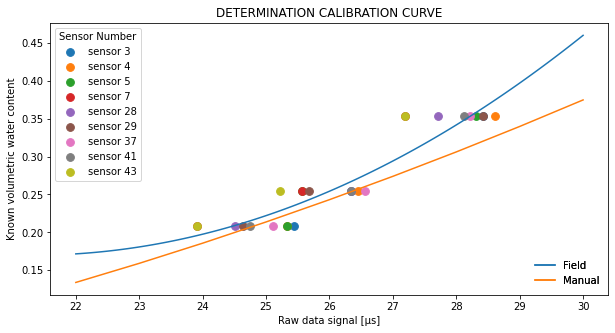

          2
0.003844 x - 0.1638 x + 1.916
0.8835858446749271


In [5]:
from sklearn.metrics import r2_score
import scipy.stats as stats

xx = np.arange(22,31)
yy = 0.0007*xx**2 - 0.0063*xx - 0.0663

model = np.poly1d(np.polyfit(Cal['RawValue'],
                             Cal['KnownVWC'], 2))
polyline = np.linspace(22, 30, 100)
fig, ax = plt.subplots(figsize=(10,5))


for i in range(44):
    if(i not in Cal.SensorNumber.tolist()):
        continue
    else:
        sensorMeasurements = Cal.loc[Cal['SensorNumber'] == i]
        scatter = ax.scatter(sensorMeasurements.RawValue, sensorMeasurements.KnownVWC, label=f"sensor {i}"
            , alpha=1, s=60)

legend = ax.legend(title="Sensor Number")
ax.add_artist(legend)

field, = plt.plot(polyline, model(polyline))
manual, = plt.plot(xx,yy)


leg = ax.legend( handles = [field, manual], labels = ['Field', 'Manual'],
               loc='lower right', frameon=False)
ax.add_artist(leg);

ax.set_ylabel('Known volumetric water content')
ax.set_xlabel('Raw data signal [µs]')
ax.set_title('DETERMINATION CALIBRATION CURVE')

plt.show()

print(model)
print(r2_score(Cal['KnownVWC'], 
               model(Cal['RawValue'])))
  

# Import field data

In [18]:
path1 = os.getcwd()
path = os.path.join(path1, 'Data_Callibration')
file = os.path.join(path, 'FieldData3.csv')
Field = pd.read_csv(file,sep=';', header=0)
Field1 = Field.iloc[:,0:38]
Data = Field1.iloc[:,[5,7,9,11,13,15,17,19,21,23,27,29,33,35,37]]
Data = Data.replace('NAN',np.nan)
Data = Data.fillna(0)
Data = Data.astype(float)
#Data['PA_uS_Avg(7)'] = Data['PA_uS_Avg(7)'] + Data['PA_uS_Avg(3)']
#Data['PA_uS_Avg(8)'] = Data['PA_uS_Avg(8)'] + Data['PA_uS_Avg(6)']
#Data.loc[:40,'PA_uS_Avg(3)'] = 0
#Data.loc[:40,'PA_uS_Avg(6)'] = 0
print(Data)
Data.to_excel('RawSignals.xlsx')

## !!!!!!!!!!!!Data format van de datum moet hetzelfde zijn als deze van de weer data

C:\Users\brasp\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (5,7,9,10,11,12,13,15,16,17,18,19,21,22,23,27,28,29,30,31,34,35,42,43,76,77,78,79,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,129,131,133,135,137,139,140,141,142,143,145,147,149,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


      PA_uS_Avg(1)  PA_uS_Avg(2)  PA_uS_Avg(3)  PA_uS_Avg(4)  PA_uS_Avg(5)  \
0            26.74         24.24          0.00          0.00          0.00   
1            27.16         26.50          0.00         25.39         25.83   
2            27.17         26.50          0.00         25.40         25.84   
3            27.18         26.50          0.00         25.40         25.84   
4            27.18         26.51          0.00         25.41         25.85   
...            ...           ...           ...           ...           ...   
5087         31.08         29.25         31.08         28.85         31.23   
5088         31.09         29.27         31.09         28.89         31.24   
5089         31.09         29.29         31.10         28.94         31.24   
5090         31.08         29.33         31.10         28.96         31.24   
5091         31.09         29.35         31.12         28.96         31.24   

      PA_uS_Avg(6)  PA_uS_Avg(7)  PA_uS_Avg(8)  PA_uS_Avg(9)  P

# Calculate volumetric water content

In [19]:
c=len(Data.columns) 
print(c)
r=len(Data)
print(r)
ColumnNumber = list(range(0, c))
print(ColumnNumber)
VWC = np.zeros((r,c))
print(VWC)

15
5092
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [20]:
for i in ColumnNumber:
    VWC[:,i] = 0.003844*Data.iloc[:,i]**2 - 0.1638*Data.iloc[:,i] + 1.916
print(VWC)

[[0.28455409 0.20413629 1.916      ... 1.916      1.916      1.916     ]
 [0.30277857 0.274749   1.916      ... 1.916      1.916      1.916     ]
 [0.30322901 0.274749   1.916      ... 1.916      1.916      1.916     ]
 ...
 [0.53902266 0.41608136 0.53977524 ... 0.38808119 0.63145025 1.916     ]
 [0.53827084 0.41854277 0.53977524 ... 0.38808119 0.63145025 1.916     ]
 [0.53902266 0.41977809 0.54128271 ... 0.38808119 0.63229201 1.916     ]]


In [21]:
VWC[VWC>1] = np.nan
print(VWC)

[[0.28455409 0.20413629        nan ...        nan        nan        nan]
 [0.30277857 0.274749          nan ...        nan        nan        nan]
 [0.30322901 0.274749          nan ...        nan        nan        nan]
 ...
 [0.53902266 0.41608136 0.53977524 ... 0.38808119 0.63145025        nan]
 [0.53827084 0.41854277 0.53977524 ... 0.38808119 0.63145025        nan]
 [0.53902266 0.41977809 0.54128271 ... 0.38808119 0.63229201        nan]]


In [22]:
VWC = pd.DataFrame(VWC)
VWC.columns =['a70','a40','d20/1','a20','b70','d40/1','b20','b40','d70/1','d20/2','d20/3','d40/3','d40/2','d70/3','d70/2']
print(VWC)

           a70       a40     d20/1       a20       b70     d40/1       b20  \
0     0.284554  0.204136       NaN       NaN       NaN       NaN  0.182871   
1     0.302779  0.274749       NaN  0.235161  0.249720       NaN  0.238339   
2     0.303229  0.274749       NaN  0.235475  0.250068       NaN  0.238661   
3     0.303680  0.274749       NaN  0.235475  0.250068       NaN  0.238661   
4     0.303680  0.275149       NaN  0.235790  0.250417       NaN  0.238984   
...        ...       ...       ...       ...       ...       ...       ...   
5087  0.538271  0.413632  0.538271  0.389818  0.549629  0.470354  0.427883   
5088  0.539023  0.414855  0.539023  0.392144  0.550392  0.470354  0.429771   
5089  0.539023  0.416081  0.539775  0.395069  0.550392  0.468999  0.431034   
5090  0.538271  0.418543  0.539775  0.396244  0.550392  0.468999  0.432300   
5091  0.539023  0.419778  0.541283  0.396244  0.550392  0.468999  0.432935   

           b40   d70/1     d20/2     d20/3     d40/3     d40/2 

In [23]:
Plotdata = Field1.iloc[:,0]
print(Plotdata)

0       2022-09-20 14:00
1       2022-09-20 14:30
2       2022-09-20 15:00
3       2022-09-20 15:30
4       2022-09-20 16:00
              ...       
5087    2023-01-04 13:30
5088    2023-01-04 14:00
5089    2023-01-04 14:30
5090    2023-01-04 15:00
5091    2023-01-04 15:30
Name: TIMESTAMP, Length: 5092, dtype: object


In [24]:
Plotdata = pd.concat([Plotdata, VWC], axis="columns")
print(Plotdata)


             TIMESTAMP       a70       a40     d20/1       a20       b70  \
0     2022-09-20 14:00  0.284554  0.204136       NaN       NaN       NaN   
1     2022-09-20 14:30  0.302779  0.274749       NaN  0.235161  0.249720   
2     2022-09-20 15:00  0.303229  0.274749       NaN  0.235475  0.250068   
3     2022-09-20 15:30  0.303680  0.274749       NaN  0.235475  0.250068   
4     2022-09-20 16:00  0.303680  0.275149       NaN  0.235790  0.250417   
...                ...       ...       ...       ...       ...       ...   
5087  2023-01-04 13:30  0.538271  0.413632  0.538271  0.389818  0.549629   
5088  2023-01-04 14:00  0.539023  0.414855  0.539023  0.392144  0.550392   
5089  2023-01-04 14:30  0.539023  0.416081  0.539775  0.395069  0.550392   
5090  2023-01-04 15:00  0.538271  0.418543  0.539775  0.396244  0.550392   
5091  2023-01-04 15:30  0.539023  0.419778  0.541283  0.396244  0.550392   

         d40/1       b20       b40   d70/1     d20/2     d20/3     d40/3  \
0          

In [25]:
Plotdata1 = Plotdata.drop(Plotdata.index[0:137])
print(Plotdata1)

             TIMESTAMP       a70       a40     d20/1       a20       b70  \
137   2022-09-23 10:30  0.309616  0.240283       NaN  0.244589  0.479927   
138   2022-09-23 11:00  0.310541  0.240283       NaN  0.244589  0.481307   
139   2022-09-23 11:30  0.309616  0.239957       NaN  0.243584  0.481307   
140   2022-09-23 12:00  0.309155  0.240283       NaN  0.242918  0.481307   
141   2022-09-23 12:30  0.309155  0.240609       NaN  0.243251  0.481998   
...                ...       ...       ...       ...       ...       ...   
5087  2023-01-04 13:30  0.538271  0.413632  0.538271  0.389818  0.549629   
5088  2023-01-04 14:00  0.539023  0.414855  0.539023  0.392144  0.550392   
5089  2023-01-04 14:30  0.539023  0.416081  0.539775  0.395069  0.550392   
5090  2023-01-04 15:00  0.538271  0.418543  0.539775  0.396244  0.550392   
5091  2023-01-04 15:30  0.539023  0.419778  0.541283  0.396244  0.550392   

         d40/1       b20       b40   d70/1     d20/2     d20/3     d40/3  \
137        

In [26]:
Timestamp = Plotdata1['TIMESTAMP']
Timestamp = pd.to_datetime(Timestamp)
a70 = Plotdata1['a70']
a40 = Plotdata1['a40']
a20 = Plotdata1['a20']
b70 = Plotdata1['b70']
b20 = Plotdata1['b20']
b40 = Plotdata1['b40']
d20w1 = Plotdata1['d20/1']
d40w1 = Plotdata1['d40/1']
d70w1 = Plotdata1['d70/1']
d20w2 = Plotdata1['d20/2']
d20w3 = Plotdata1['d20/3']
d40w3 = Plotdata1['d40/3']
d40w2 = Plotdata1['d40/2']
d70w3 = Plotdata1['d70/3']
d70w2 = Plotdata1['d70/2']
print(Timestamp)
print(d70w2)

137    2022-09-23 10:30:00
138    2022-09-23 11:00:00
139    2022-09-23 11:30:00
140    2022-09-23 12:00:00
141    2022-09-23 12:30:00
               ...        
5087   2023-01-04 13:30:00
5088   2023-01-04 14:00:00
5089   2023-01-04 14:30:00
5090   2023-01-04 15:00:00
5091   2023-01-04 15:30:00
Name: TIMESTAMP, Length: 4955, dtype: datetime64[ns]
137    NaN
138    NaN
139    NaN
140    NaN
141    NaN
        ..
5087   NaN
5088   NaN
5089   NaN
5090   NaN
5091   NaN
Name: d70/2, Length: 4955, dtype: float64


(738421.0, 738525.0)

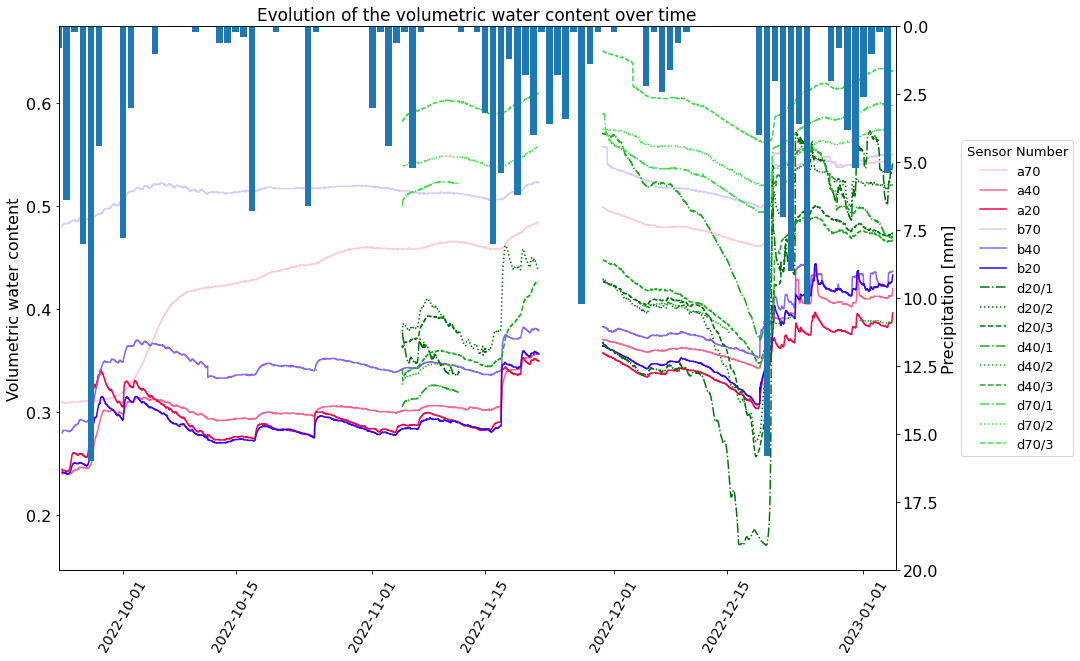

In [27]:
date1=datetime.date(2022,9,23)
date2=datetime.date(2023,1,5)
ftsz=16

fig, ax= plt.subplots(figsize=(15,10))
axb=ax.twinx()

ax.plot(Timestamp, a70, label='a70', color='#fccad8')
ax.plot(Timestamp, a40, label='a40', color='#fc6590')
ax.plot(Timestamp, a20, label='a20', color='#fc0048')
ax.plot(Timestamp, b70, label='b70', color='#d8ccff')
ax.plot(Timestamp, b40, label='b40', color ='#8a66ff')
ax.plot(Timestamp, b20, label='b20', color='#3c00ff')

ax.plot(Timestamp, d20w1, label='d20/1', color='#017309', linestyle = 'dashdot')
ax.plot(Timestamp, d20w2, label='d20/2', color='#017309', linestyle = 'dotted')
ax.plot(Timestamp, d20w3, label='d20/3', color='#017309', linestyle = 'dashed')

ax.plot(Timestamp, d40w1, label='d40/1', color='#1aab23', linestyle = 'dashdot')
ax.plot(Timestamp, d40w2, label='d40/2', color='#1aab23', linestyle = 'dotted')
ax.plot(Timestamp, d40w3, label='d40/3', color='#1aab23', linestyle = 'dashed')

ax.plot(Timestamp, d70w1, label='d70/1', color='#42db4c', linestyle = 'dashdot')
ax.plot(Timestamp, d70w2, label='d70/2', color='#42db4c', linestyle = 'dotted')
ax.plot(Timestamp, d70w3, label='d70/3', color='#42db4c', linestyle = 'dashed')

ax.set_title('Evolution of the volumetric water content over time', fontsize = ftsz+1)
ax.legend(title='Sensor Number',title_fontsize = ftsz-3, bbox_to_anchor = (1.22, 0.5), loc='center right', fontsize=ftsz-3)
ax.set_ylabel('Volumetric water content', fontsize= ftsz)
ax.tick_params(axis='x', which='both', labelsize=ftsz-2,rotation=60)
ax.tick_params(axis='y', which='both', labelsize=ftsz)
axb.bar(climday['date'],climday.precipitation_sum)
axb.set_ylim([0, 20])
axb.invert_yaxis()
axb.set_ylabel('Precipitation [mm]', fontsize= ftsz)
axb.tick_params(axis='x', which='both', labelsize=ftsz)
axb.tick_params(axis='y', which='both', labelsize=ftsz)

axb.set_xlim([date1,date2])

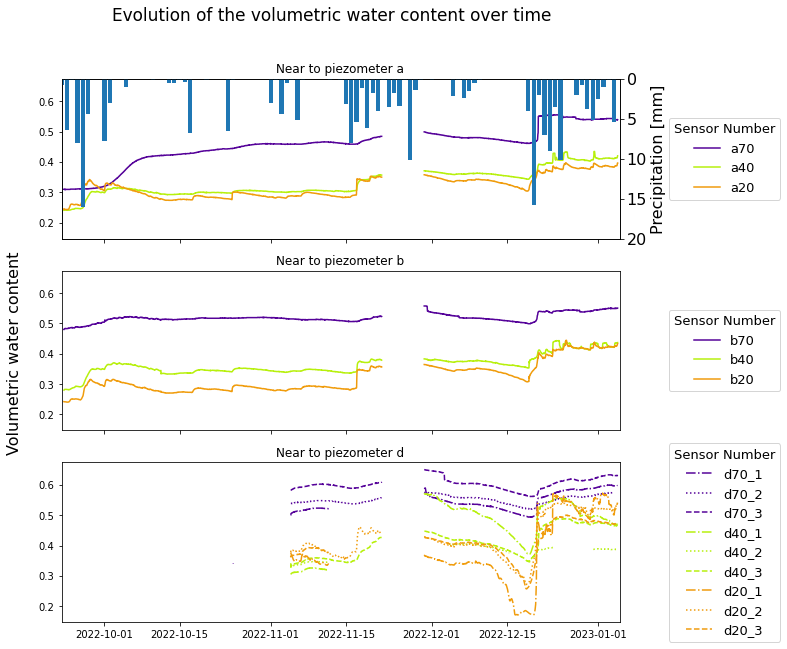

In [28]:
date1=datetime.date(2022,9,23)
date2=datetime.date(2023,1,5)
ftsz=16

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True, figsize=(10,10))
fig.suptitle('Evolution of the volumetric water content over time', fontsize = ftsz+1)
axb=ax1.twinx()
ax1.plot(Timestamp, a70, label='a70', color='#550299')
ax1.plot(Timestamp, a40, label='a40', color='#b7f00c')
ax1.plot(Timestamp, a20, label='a20', color='#f09c0c')
ax1.set_title('Near to piezometer a')
ax1.legend(title='Sensor Number',title_fontsize = ftsz-3, bbox_to_anchor = (1.3, 0.5), loc='center right', fontsize=ftsz-3)
axb.bar(climday['date'],climday.precipitation_sum)
axb.set_ylim([0, 20])
axb.invert_yaxis()
axb.set_ylabel('Precipitation [mm]', fontsize= ftsz)
axb.tick_params(axis='x', which='both', labelsize=ftsz)
axb.tick_params(axis='y', which='both', labelsize=ftsz)
axb.set_xlim([date1,date2])

ax2.plot(Timestamp, b70, label='b70', color='#550299')
ax2.plot(Timestamp, b40, label='b40', color ='#b7f00c')
ax2.plot(Timestamp, b20, label='b20', color='#f09c0c')
ax2.set_title('Near to piezometer b')
ax2.legend(title='Sensor Number',title_fontsize = ftsz-3, bbox_to_anchor = (1.3, 0.5), loc='center right', fontsize=ftsz-3)

ax3.plot(Timestamp, d70w1, label='d70_1', color='#550299', linestyle = 'dashdot')
ax3.plot(Timestamp, d70w2, label='d70_2', color='#550299', linestyle = 'dotted')
ax3.plot(Timestamp, d70w3, label='d70_3', color='#550299', linestyle = 'dashed')

ax3.plot(Timestamp, d40w1, label='d40_1', color='#b7f00c', linestyle = 'dashdot')
ax3.plot(Timestamp, d40w2, label='d40_2', color='#b7f00c', linestyle = 'dotted')
ax3.plot(Timestamp, d40w3, label='d40_3', color='#b7f00c', linestyle = 'dashed')

ax3.plot(Timestamp, d20w1, label='d20_1', color='#f09c0c', linestyle = 'dashdot')
ax3.plot(Timestamp, d20w2, label='d20_2', color='#f09c0c', linestyle = 'dotted')
ax3.plot(Timestamp, d20w3, label='d20_3', color='#f09c0c', linestyle = 'dashed')
ax3.set_title('Near to piezometer d')
ax3.legend(title='Sensor Number',title_fontsize = ftsz-3, bbox_to_anchor = (1.3, 0.5), loc='center right', fontsize=ftsz-3)

fig.text(0.06, 0.5, 'Volumetric water content', ha='center', va='center', fontsize= ftsz, rotation='vertical')

plt.savefig("VWC.png", bbox_inches = 'tight')
